# Safety Dataset Preprocessing and EDA
by Prince Joseph Erneszer Javier

**Notes on Virtual Machine and Environment**
<br>Virtual Machine: AWS c5.9xlarge
<br>Operating System: Deep Learning AMI (Ubuntu) Version 23.0
<br>Environment: tensorflow_p36
<br>Storage Size: 85 GB

## Executive Summary

In this notebook, we load and process data for Grab AI for SEA challenge under the Safety category. We were provided Telematics data and from these data we would develop models that can predict if a driver is driving safely or not. The raw features dataset contains 16 million samples and 11 columns including the `bookingID`. There are 20,000 unique `bookingID`'s each with either 0 or 1 corresponding to safe or unsafe driving. In this notebook, we loaded the data, engineered features, sampled the data, and saved the processed data to be used to train the machine learning classifiers in the notebook `grab-ai-training`. `grab-ai-testing` contains the trained models predicting on test data. Finally, `grab-ai-predicting` contains the pipeline for predicting on a new dataset.

The following preprocessing were performed in this notebook: the features data saved in multiple CSVs were concatenated into one dataframe, a 5% test data from the features dataset was separated from the 95% training data, features were engineered and samples were aggregated per `bookingID`, the class labels of 0 or 1 per `bookingID` was concatenated to the aggregated and engineered feature set. Finally, since the classes were imbalanced, the number of classes were equalized to be 50-50 for the machine learning models. The final processed datasets were saved as CSV files.

## Introduction

Grab AI for SEA challenge is a hackathon organized by Grab. Grab offers three challenges that can be solved using AI: Traffic Management, Computer Vision, and Safety. We tackle the Safety Challenge. The `Ride Safety` dataset was provided by Grab, which contains Telematics data (acceleration, gyroscope data, speed, etc.), `bookingID`, and labels (0 or 1 for safe or unsafe driving). The raw dataset was prepared for the machine learning models in `grab-ai-training` notebook.

## About the Data

The `Ride Safety` dataset contains two folders: `features` and `labels`. `features` contains 10 CSV files which contain a total of 16 million telematics data samples. The columns in the `features` dataset as described in `data_dictionary.xlsx` are:

|Column Name|Description|
|:--|:--|
|`bookingID`|trip id|
|`Accuracy`|accuracy inferred by GPS in meters|
|`Bearing`|GPS bearing|
|`acceleration_x`|accelerometer reading in x axis (m/s2)|
|`acceleration_y`|accelerometer reading in y axis (m/s2)|
|`acceleration_z`|accelerometer reading in z axis (m/s2)|
|`gyro_x`|gyroscope reading in x axis (rad/s)|
|`gyro_y`|gyroscope reading in y axis (rad/s)|
|`gyro_z`|gyroscope reading in z axis (rad/s)|
|`second`|time of the record by number of seconds|
|`Speed`|speed measured by GPS in m/s|

## Preprocessing

In [1]:
# loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from collections import Counter
from scipy.stats import kurtosis, skew
from scipy.signal import periodogram
import multiprocessing
from sklearn.utils import shuffle

import warnings
warnings.simplefilter('ignore')

### Loading the Data

There are two folders `features` and `labels` and one excel file `data_dictionary.xlsx`.

In [2]:
# check the dataset folders
!ls data/safety/

data_dictionary.xlsx  features	labels


We read `data_dictionary.xlsx` and check the contents.

In [3]:
# read the data dictionary
xl = pd.ExcelFile("data/safety/data_dictionary.xlsx")

In [4]:
# sheet names
xl.sheet_names

['telematics data', 'labels']

In [5]:
# let's see the first sheet
xl.parse('telematics data')

,Unnamed: 0,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,description,trip id,accuracy inferred by GPS in meters,GPS bearing,accelerometer reading in x axis (m/s2),accelerometer reading in y axis (m/s2),accelerometer reading in z axis (m/s2),gyroscope reading in x axis (rad/s),gyroscope reading in y axis (rad/s),gyroscope reading in z axis (rad/s),time of the record by number of seconds,speed measured by GPS in m/s
1,samples,1,5,303.695,-0.00636292,-0.393829,-0.922379,"-0.020000606102604086,0.03205247529964867,-0.0...",NaN,NaN,0,0.57
2,NaN,1,10,325.39,0.183914,-0.355026,-0.92041,"-0.028598887998033916,0.025720543491876274,-0....",NaN,NaN,1,0.28
3,NaN,1,5,303.695,-0.00636292,-0.392944,-0.922226,"-0.01894040167264354,0.030980020328673762,-0.0...",NaN,NaN,2,0.57
4,NaN,1,10,324.23,0.165924,-0.332092,-0.920578,"-0.0577245492596855,0.002558232543130116,0.014...",NaN,NaN,3,0.28
5,NaN,1,5,303.695,-0.00642395,-0.392166,-0.924164,"-0.017865283540578553,0.03203915949419828,-0.0...",NaN,NaN,4,0.57
6,NaN,1,10,324.23,0.169724,-0.333694,-0.939575,"-0.04030587783391324,0.03112276576310201,-0.00...",NaN,NaN,5,0.28
7,NaN,1,5,303.695,-0.00480652,-0.391861,-0.923065,"-0.020006731373111267,0.03205726898961082,-0.0...",NaN,NaN,6,0.57
8,NaN,2,10,322.99,0.174759,-0.344498,-0.918839,"-0.00411618178082647,0.02562493600874243,0.004...",NaN,NaN,0,0.28
9,NaN,2,5,303.695,-0.00646973,-0.391953,-0.923889,"-0.0189390700920985,0.032050611086885616,-0.00...",NaN,NaN,1,0.57


In [6]:
# let's see the second sheet
xl.parse('labels')

,bookingID,label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
5,6,1
6,7,1
7,8,1
8,9,0
9,10,0


We then checked the contents of `features`. There are 10 CSV files.

In [7]:
# let's see the contents of features and labels folder
!ls data/safety/features

# there are many csvs, we either want to run this in Pyspark 
# or we can combine them into just one Pandas dataset

part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00008-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv
part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv


`labels` contains only one CSV file.

In [8]:
!ls data/safety/labels

part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv


Below shows some contents of one CSV file in `features`.

In [9]:
# let's load one features csv, there are many csvs we either
_ = pd.read_csv(
    "data/safety/features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv")
_.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


Below are some of the contents in the CSV file inside `labels`.

In [10]:
# let's load the labels csv
labels = pd.read_csv(
    "data/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

# drop duplicates
labels = labels.dropna()

# sort
labels.sort_values(by="bookingID", inplace=True)
labels.reset_index(drop=True, inplace=True)

labels.head()

,bookingID,label
0,0,0
1,1,1
2,2,1
3,4,1
4,6,0


There are no null values in the `labels` dataset.

In [11]:
# how many null
labels.isnull().sum()

bookingID    0
label        0
dtype: int64

There are 20,018 rows in the `labels` dataset but there are only 20,000 unique `bookingID`. We will remove the duplicates later.

In [12]:
# how many labels are there?
len(labels)

20018

In [13]:
# how many unique bookings are there?
len(labels.bookingID.unique())

20000

We then combined the 10 CSV files under `features` into one Pandas dataframe.

In [14]:
# load all paths into list
paths = glob.glob("data/safety/features/*.csv")

# let's combine all feature into one pandas dataframe
df_feats0 = pd.DataFrame()

for path in paths:
    _ = pd.read_csv(path, header="infer")
    df_feats0 = pd.concat([df_feats0, _])

In [15]:
df_feats0.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1657857376413,10.000,128.234833,0.780280,-9.869086,-0.019440,-0.143924,-0.016662,-0.016986,497.0,16.030001
1,25769803913,6.000,286.368225,9.086713,0.309390,-3.506772,0.008518,-0.006350,0.003299,120.0,2.089626
2,1434519076946,12.136,339.000000,0.946808,9.609665,2.311615,-0.011124,-0.320435,-0.062027,76.0,5.540000
3,283467841697,3.000,186.000000,0.900247,7.996878,5.286559,0.000874,-0.009702,0.020248,22.0,0.276720
4,481036337236,3.090,18.000000,0.045000,9.882000,0.173000,0.038839,-0.284030,-0.078576,1522.0,1.306365


In [16]:
df_feats0.shape

(16135561, 11)

We dropped any duplicates in the combined `features` dataset.

In [17]:
# drop duplicates
df_feats0 = df_feats0.drop_duplicates()

Great that there are no null values in the dataset.

In [18]:
# count null values
df_feats0.isnull().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

We then sorted the dataset by `bookingID` and `second` for organization.

In [19]:
# sorting by booking number and seconds
df_feats0 = df_feats0.sort_values(
    by=["bookingID", "second"]).reset_index(drop=True)
df_feats0.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


Next, we set aside 5% of all bookinIDs in the features dataset as test set.

In [20]:
np.random.seed(42)

# setting aside test data 5% of all booking IDs
num_test = int(len(df_feats0.bookingID.unique()) * 0.05)
print(num_test)

# select random booking IDs
test_bookingIDs = np.random.choice(
    df_feats0.bookingID.unique(), num_test, replace=False)
train_bookingIDs = [i for i in df_feats0.bookingID.unique()
                    if i not in test_bookingIDs]
df_test = df_feats0[df_feats0.bookingID.isin(test_bookingIDs)]
df_train = df_feats0[df_feats0.bookingID.isin(train_bookingIDs)]

1000


We save the test set into `df_test.csv` and the training set into `df_train.csv`.

In [21]:
# save to csv df_test
df_test.to_csv("data/processed/df_test.csv", index=False)
df_train.to_csv("data/processed/df_train.csv", index=False)

In [22]:
# load csv
df_test = pd.read_csv("data/processed/df_test.csv")
df_train = pd.read_csv("data/processed/df_train.csv")

### Feature Engineering

Since the labels are per `bookingID`, we decided to aggregate the features dataset into `bookingID`. We also removed `second` as a feature because this merely keeps track of time. For each feature in the original dataset, we calculated new metrics, namely:
1. minimum
* maximum
* range
* mean
* standard deviation (approximates spread)
* skewness (left or right tailed)
* kurtosis (approximates amount of outliers)
* fourier transform periodogram dominant frequency (seasonality)
* fourier transform periodogram maximum power corresponding to dominant frequency (strength of seasonality)
* length of each trip

In [23]:
def dominant_f(y):
    """Given time series y, get frequency of maximum power
    from periodogram"""
    f, p = periodogram(y, scaling='spectrum')
    ind = np.argsort(p)
    f_max = f[ind[-1]]
    return f_max


def max_power(y):
    """Given time series y, get maximum power"""
    f, p = periodogram(y, scaling='spectrum')
    return p.max()

In [24]:
# since there is only one label per bookingID, we engineer features per booking trip
# getting min, max, range, mean, std, skewness, and kurtosis, dominant fft freq, and max fft power

df_engg_feats = df_train.drop("second", axis=1)
df_engg_feats = df_engg_feats.groupby(by="bookingID", as_index=True).agg(
    [np.min, np.max, np.ptp, np.mean, np.std, skew, kurtosis, dominant_f, max_power])
df_engg_feats.head()

Accuracy                                                           \
              amin    amax     ptp       mean       std      skew  kurtosis   
bookingID                                                                     
0              4.0  48.000  44.000  10.165339  3.855898  1.732696  8.764958   
1              3.0   7.709   4.709   3.718763  0.597933  1.259239  5.437314   
2              3.0   8.000   5.000   3.930626  1.117354  1.325234  0.930249   
4             10.0  10.000   0.000  10.000000  0.000000  0.000000 -3.000000   
6              3.0  12.000   9.000   4.586721  1.329545  1.697510  5.095780   

                                 Bearing  ...    gyro_z Speed             \
          dominant_f max_power      amin  ... max_power  amin       amax   
bookingID                                 ...                              
0           0.000996  5.347346  0.037464  ...  0.000046  -1.0  22.946083   
1           0.007051  0.039890  0.000000  ...  0.000029  -1.0  21.882141   
2           0.005128  0.350277  1.000000  ...  0.000060   0.0   9.360483   
4           0.500000  0.000000  2.271227  ...  0.000089   0.0  19.780001   
6           0.000913  0.136522  0.000000  ...  0.000034   0.0  16.394695   

                                                                         \
                 ptp      mean       std      skew  kurtosis dominant_f   
bookingID                                                                 
0          23.946083  8.994822  7.199919  0.167588 -1.431322   0.000996   
1          22.882141  7.881588  7.059362  0.347213 -1.243763   0.002350   
2           9.360483  3.157213  2.897762  0.407362 -1.068416   0.005128   
4          19.780001  6.150996  5.595901  0.872207 -0.638173   0.000914   
6          16.394695  4.628921  5.314844  0.723716 -1.001236   0.000913   

                      
           max_power  
bookingID             
0          28.890331  
1          13.413249  
2           3.952531  
4           9.145061  
6           9.048749  

[5 rows x 81 columns]

In [25]:
# flatten column names
cols = [df_engg_feats.columns[i][0] + "_" + df_engg_feats.columns[i][1]
        for i in range(len(df_engg_feats.columns))]
cols[:5]

['Accuracy_amin',
 'Accuracy_amax',
 'Accuracy_ptp',
 'Accuracy_mean',
 'Accuracy_std']

In [26]:
df_engg_feats.columns = cols
df_engg_feats.reset_index(inplace=True)
df_engg_feats.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,gyro_z_max_power,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power
0,0,4.0,48.000,44.000,10.165339,3.855898,1.732696,8.764958,0.000996,5.347346,...,0.000046,-1.0,22.946083,23.946083,8.994822,7.199919,0.167588,-1.431322,0.000996,28.890331
1,1,3.0,7.709,4.709,3.718763,0.597933,1.259239,5.437314,0.007051,0.039890,...,0.000029,-1.0,21.882141,22.882141,7.881588,7.059362,0.347213,-1.243763,0.002350,13.413249
2,2,3.0,8.000,5.000,3.930626,1.117354,1.325234,0.930249,0.005128,0.350277,...,0.000060,0.0,9.360483,9.360483,3.157213,2.897762,0.407362,-1.068416,0.005128,3.952531
3,4,10.0,10.000,0.000,10.000000,0.000000,0.000000,-3.000000,0.500000,0.000000,...,0.000089,0.0,19.780001,19.780001,6.150996,5.595901,0.872207,-0.638173,0.000914,9.145061
4,6,3.0,12.000,9.000,4.586721,1.329545,1.697510,5.095780,0.000913,0.136522,...,0.000034,0.0,16.394695,16.394695,4.628921,5.314844,0.723716,-1.001236,0.000913,9.048749


In [27]:
# add length of each trip
df_len = df_train.groupby(by="bookingID", as_index=True).agg(len).iloc[:, 0:1]
df_len.columns = ['trip_len']
df_len.reset_index(inplace=True)
df_len.head()

,bookingID,trip_len
0,0,1004.0
1,1,851.0
2,2,195.0
3,4,1094.0
4,6,1095.0


In [28]:
# merge along bookingID
df_engg_feats_2 = pd.merge(df_engg_feats, df_len, how="inner", on="bookingID")
df_engg_feats_2.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len
0,0,4.0,48.000,44.000,10.165339,3.855898,1.732696,8.764958,0.000996,5.347346,...,-1.0,22.946083,23.946083,8.994822,7.199919,0.167588,-1.431322,0.000996,28.890331,1004.0
1,1,3.0,7.709,4.709,3.718763,0.597933,1.259239,5.437314,0.007051,0.039890,...,-1.0,21.882141,22.882141,7.881588,7.059362,0.347213,-1.243763,0.002350,13.413249,851.0
2,2,3.0,8.000,5.000,3.930626,1.117354,1.325234,0.930249,0.005128,0.350277,...,0.0,9.360483,9.360483,3.157213,2.897762,0.407362,-1.068416,0.005128,3.952531,195.0
3,4,10.0,10.000,0.000,10.000000,0.000000,0.000000,-3.000000,0.500000,0.000000,...,0.0,19.780001,19.780001,6.150996,5.595901,0.872207,-0.638173,0.000914,9.145061,1094.0
4,6,3.0,12.000,9.000,4.586721,1.329545,1.697510,5.095780,0.000913,0.136522,...,0.0,16.394695,16.394695,4.628921,5.314844,0.723716,-1.001236,0.000913,9.048749,1095.0


We saved the feature engineered and aggregated training set to `engg_feats_labels.csv`.

In [29]:
# left join with labels (aggregating and feature engineering)
df_engg_feats_labels = pd.merge(
    df_engg_feats_2, labels, how="inner", on="bookingID")

# save to CSV
save_path = "data/processed/engg_feats_labels.csv"
df_engg_feats_labels.to_csv(save_path, index=False)

In [30]:
df_engg_feats_labels.shape

(19017, 84)

In [31]:
df_engg_feats_labels.head()

,bookingID,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,...,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len,label
0,0,4.0,48.000,44.000,10.165339,3.855898,1.732696,8.764958,0.000996,5.347346,...,22.946083,23.946083,8.994822,7.199919,0.167588,-1.431322,0.000996,28.890331,1004.0,0
1,1,3.0,7.709,4.709,3.718763,0.597933,1.259239,5.437314,0.007051,0.039890,...,21.882141,22.882141,7.881588,7.059362,0.347213,-1.243763,0.002350,13.413249,851.0,1
2,2,3.0,8.000,5.000,3.930626,1.117354,1.325234,0.930249,0.005128,0.350277,...,9.360483,9.360483,3.157213,2.897762,0.407362,-1.068416,0.005128,3.952531,195.0,1
3,4,10.0,10.000,0.000,10.000000,0.000000,0.000000,-3.000000,0.500000,0.000000,...,19.780001,19.780001,6.150996,5.595901,0.872207,-0.638173,0.000914,9.145061,1094.0,1
4,6,3.0,12.000,9.000,4.586721,1.329545,1.697510,5.095780,0.000913,0.136522,...,16.394695,16.394695,4.628921,5.314844,0.723716,-1.001236,0.000913,9.048749,1095.0,0


In [32]:
df_engg_feats_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19017 entries, 0 to 19016
Data columns (total 84 columns):
bookingID                    19017 non-null int64
Accuracy_amin                19017 non-null float64
Accuracy_amax                19017 non-null float64
Accuracy_ptp                 19017 non-null float64
Accuracy_mean                19017 non-null float64
Accuracy_std                 19017 non-null float64
Accuracy_skew                19017 non-null float64
Accuracy_kurtosis            19017 non-null float64
Accuracy_dominant_f          19017 non-null float64
Accuracy_max_power           19017 non-null float64
Bearing_amin                 19017 non-null float64
Bearing_amax                 19017 non-null float64
Bearing_ptp                  19017 non-null float64
Bearing_mean                 19017 non-null float64
Bearing_std                  19017 non-null float64
Bearing_skew                 19017 non-null float64
Bearing_kurtosis             19017 non-null float64
Bearing_d

In [33]:
# load saved combined dataset
save_path = "data/processed/engg_feats_labels.csv"
df_engg_feats_labels0 = pd.read_csv(save_path)
df_engg_feats_labels0.drop("bookingID", axis=1, inplace=True)
df_engg_feats_labels0.head()

,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,Bearing_amin,...,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len,label
0,4.0,48.000,44.000,10.165339,3.855898,1.732696,8.764958,0.000996,5.347346,0.037464,...,22.946083,23.946083,8.994822,7.199919,0.167588,-1.431322,0.000996,28.890331,1004.0,0
1,3.0,7.709,4.709,3.718763,0.597933,1.259239,5.437314,0.007051,0.039890,0.000000,...,21.882141,22.882141,7.881588,7.059362,0.347213,-1.243763,0.002350,13.413249,851.0,1
2,3.0,8.000,5.000,3.930626,1.117354,1.325234,0.930249,0.005128,0.350277,1.000000,...,9.360483,9.360483,3.157213,2.897762,0.407362,-1.068416,0.005128,3.952531,195.0,1
3,10.0,10.000,0.000,10.000000,0.000000,0.000000,-3.000000,0.500000,0.000000,2.271227,...,19.780001,19.780001,6.150996,5.595901,0.872207,-0.638173,0.000914,9.145061,1094.0,1
4,3.0,12.000,9.000,4.586721,1.329545,1.697510,5.095780,0.000913,0.136522,0.000000,...,16.394695,16.394695,4.628921,5.314844,0.723716,-1.001236,0.000913,9.048749,1095.0,0


In [34]:
df_feats = df_engg_feats_labels0.drop("label", axis=1)
df_feats.head()

,Accuracy_amin,Accuracy_amax,Accuracy_ptp,Accuracy_mean,Accuracy_std,Accuracy_skew,Accuracy_kurtosis,Accuracy_dominant_f,Accuracy_max_power,Bearing_amin,...,Speed_amin,Speed_amax,Speed_ptp,Speed_mean,Speed_std,Speed_skew,Speed_kurtosis,Speed_dominant_f,Speed_max_power,trip_len
0,4.0,48.000,44.000,10.165339,3.855898,1.732696,8.764958,0.000996,5.347346,0.037464,...,-1.0,22.946083,23.946083,8.994822,7.199919,0.167588,-1.431322,0.000996,28.890331,1004.0
1,3.0,7.709,4.709,3.718763,0.597933,1.259239,5.437314,0.007051,0.039890,0.000000,...,-1.0,21.882141,22.882141,7.881588,7.059362,0.347213,-1.243763,0.002350,13.413249,851.0
2,3.0,8.000,5.000,3.930626,1.117354,1.325234,0.930249,0.005128,0.350277,1.000000,...,0.0,9.360483,9.360483,3.157213,2.897762,0.407362,-1.068416,0.005128,3.952531,195.0
3,10.0,10.000,0.000,10.000000,0.000000,0.000000,-3.000000,0.500000,0.000000,2.271227,...,0.0,19.780001,19.780001,6.150996,5.595901,0.872207,-0.638173,0.000914,9.145061,1094.0
4,3.0,12.000,9.000,4.586721,1.329545,1.697510,5.095780,0.000913,0.136522,0.000000,...,0.0,16.394695,16.394695,4.628921,5.314844,0.723716,-1.001236,0.000913,9.048749,1095.0


## Exploratory Data Analysis

We look at the correlation coefficients between each feature and the classification visualized through a matrix.

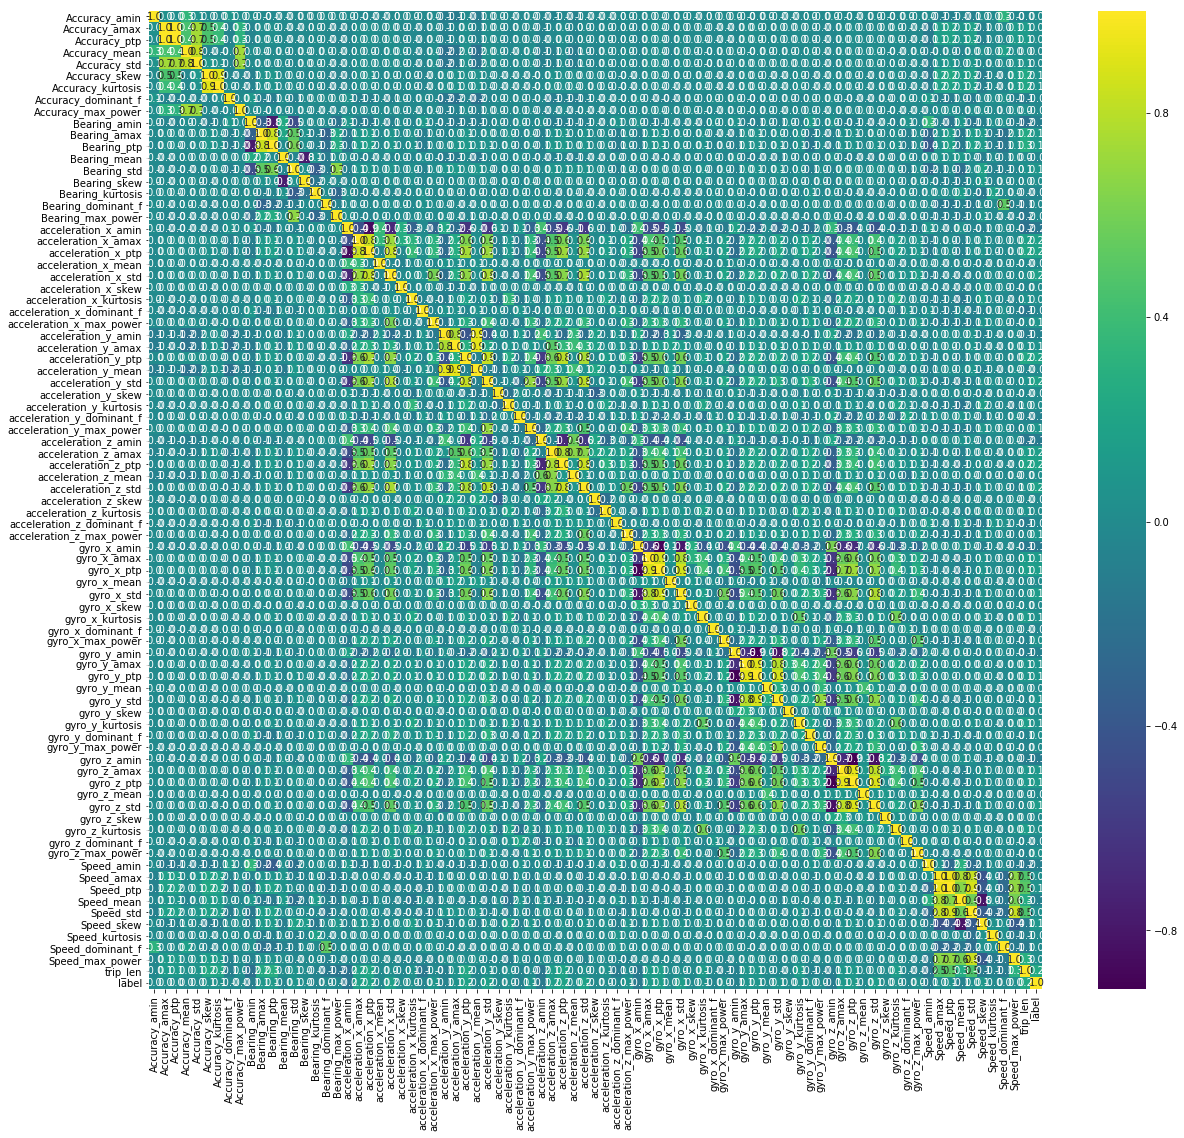

In [35]:
# we look at the correlations between the features using a covariance matrix
plt.figure(figsize=(20, 18))

df_corr_matrix = pd.DataFrame(np.corrcoef(df_engg_feats_labels0.values.T),
                              index=df_engg_feats_labels0.columns, columns=df_engg_feats_labels0.columns)
# heatmap
sns.heatmap(df_corr_matrix, annot=True, fmt='0.1f', cmap="viridis")

We also look at the correlation values of each feature with respect to the class.

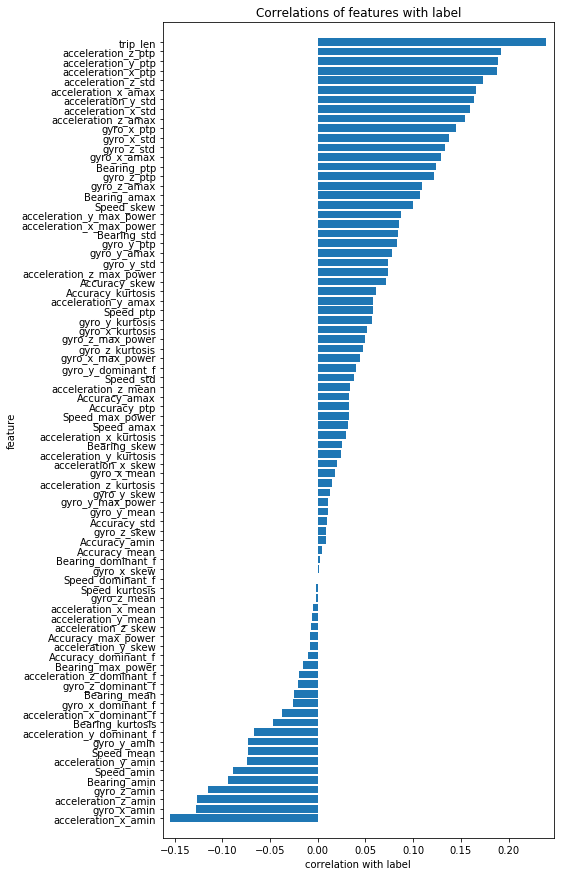

In [36]:
plt.figure(figsize=(7, 15))

# barplot
y = df_corr_matrix.iloc[:, -1].drop("label").values
x = df_corr_matrix.iloc[:, [-1]].drop("label").index
inds = np.argsort(y)
y = y[inds]
x = x[inds]
plt.barh(x, y)
plt.title("Correlations of features with label")
plt.xlabel("correlation with label")
plt.ylabel("feature")
plt.margins(0.02)

Finally, we count the number of samples per class in our training set. There are 14,268 samples in class 0 and 4,747 samples in class 1 in our training set.

Counter({0: 14265, 1: 4752})


Text(0, 0.5, 'counts')

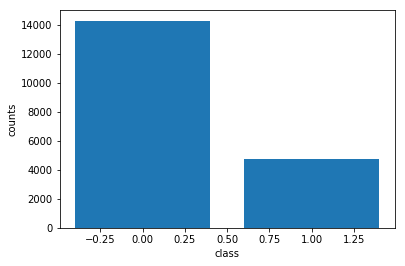

In [37]:
# number of samples per class
print(Counter(df_engg_feats_labels0.label))
y = Counter(df_engg_feats_labels0.label).values()
x = Counter(df_engg_feats_labels0.label).keys()

plt.bar(x, y)
plt.xlabel("class")
plt.ylabel("counts")

## Preprocessing for Models

We prefer to have equal number of samples per class to avoid any bias in the machine learning model and any misleading reports on the accuracy. Since there are more class 0 than class 1, we get a sample of class 0 with equal number as class 1 samples.

In [38]:
# equalizing the number of classes
# getting number of samples for class 1 (lower)
num_per_class = len(df_engg_feats_labels0[df_engg_feats_labels0.label == 1])
print(num_per_class)

# getting a sample for class 1
df_labels_1 = df_engg_feats_labels0[df_engg_feats_labels0.label == 1].sample(
    n=num_per_class, replace=False, random_state=42)

# getting a sample for class 0
df_labels_0 = df_engg_feats_labels0[df_engg_feats_labels0.label == 0].sample(
    n=num_per_class, replace=False, random_state=42)
print(len(df_labels_0))

4752
4752


The dataset for machine learning has 9,494 rows and 83 columns.

In [39]:
# concatenate and shuffle
df_for_ml = shuffle(pd.concat([df_labels_1, df_labels_0]),
                    random_state=42).reset_index(drop=True)

# shape
df_for_ml.shape

(9504, 83)

Finally, we save to `df_for_ml.csv`. This will be the dataset that will be fed into the classification models in `grab-ai-training`.

In [40]:
# save
df_for_ml.to_csv("data/processed/df_for_ml.csv", index=False)